In [72]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [73]:
# Constants (remaining the same)
k_B = 1.38e-23                  # Boltzmann constant in J/K
epsilon_r = 78.5                # Relative permittivity of water
epsilon_0 = 8.85e-12            # Permittivity of vacuum in F/m
phi_c = 0.646                   # Critical volume fraction
alpha = 0.85                    # Shear effect parameter
xi = 0.35                     #change!!!!  # Dimensionless parameter
e = 1.602e-19                   # Elementary charge in C
N_A = 6.0221e23                 # Avogadro's number in mol⁻¹
z = 1                           # Valence of the ions (monovalent)
c_0 = 10                        # Bulk molar concentration in mol/m³ (10 mM)

def compute_lambda_D(T, I):
    numerator = epsilon_r * epsilon_0 * k_B * T
    denominator = 2 * e**2 * N_A * I * 1e3
    lambda_D = np.sqrt(numerator / denominator)
    return lambda_D

def F_int(phi_d, a, xi, sigma):
    return 4 * np.pi * xi * sigma * (a**2) * (phi_d**2)

def F_ent(phi, phi_d, gamma, T):
    term = phi_c + phi_d - phi - alpha * gamma**2
    if term <= 0:
        return np.inf  # Avoid log of non-positive number
    return -3 * k_B * T * np.log(term)

def F_elec(phi_d, phi, gamma, T, a, psi_0, lambda_D):
    term = phi_c + phi_d - alpha * gamma**2
    if term <= 0:
        return np.inf
    h = 2 * (phi_c)**(1/3) * a * (phi**(-1/3) - term**(-1/3))
    if h <= 0:
        return np.inf
    numerator = 2 * np.pi * a**2 * epsilon_r * epsilon_0 * psi_0**2 * np.exp(-h / lambda_D)
    return numerator / h

def F_tot(phi_d, phi, gamma, T, a, xi, sigma, psi_0, lambda_D):
    return (F_int(phi_d, a, xi, sigma) +
            F_ent(phi, phi_d, gamma, T) +
            F_elec(phi_d, phi, gamma, T, a, psi_0, lambda_D))

def find_min_phi_d(phi, gamma, T, a, xi, sigma, psi_0, lambda_D):
    boundary_condition = phi_c - phi - alpha * gamma**2
    if boundary_condition > 0:
        lower_bound = 0.0
    else:
        lower_bound = phi + alpha * gamma**2 - phi_c
    # Ensure upper_bound is greater than lower_bound
    upper_bound = max(lower_bound + 1e-6, 1.0)
    def objective(phi_d):
        return F_tot(phi_d, phi, gamma, T, a, xi, sigma, psi_0, lambda_D)
    result = minimize_scalar(objective, bounds=(lower_bound, upper_bound), method='bounded')
    if result.success:
        return result.x
    else:
        return np.nan

def compute_G_p_tot(T, phi, a, I, sigma, psi_0):
    V_drop = (4/3) * np.pi * a**3 
    lambda_D = compute_lambda_D(T, I)

    gamma_vals = np.linspace(0, 0.01, num=50)
    F_tot_star_list = []

    for gamma in gamma_vals:
        phi_d_star = find_min_phi_d(phi, gamma, T, a, xi, sigma, psi_0, lambda_D)
        if np.isnan(phi_d_star) or np.isinf(phi_d_star):
            F_tot_star = np.nan
        else:
            F_tot_star = F_tot(phi_d_star, phi, gamma, T, a, xi, sigma, psi_0, lambda_D)
        F_tot_star_list.append(F_tot_star)

    gamma_array = np.array(gamma_vals)
    F_tot_star_array = np.array(F_tot_star_list)

    # Handle NaN values before interpolation
    valid_indices = ~np.isnan(F_tot_star_array)
    if np.sum(valid_indices) < 4:  # CubicSpline requires at least 4 points
        return np.nan

    gamma_array_valid = gamma_array[valid_indices]
    F_tot_star_array_valid = F_tot_star_array[valid_indices]

    spline_tot = CubicSpline(gamma_array_valid, F_tot_star_array_valid)
    gamma_eval = 0.0
    second_derivative_tot = spline_tot.derivative(2)(gamma_eval)

    G_p_tot = (phi / V_drop) * second_derivative_tot

    return G_p_tot



In [74]:
# Mayo1
xi = 0.34
T_exp = 298
phi_exp = 0.75
a_exp = 1e-6 * 0.5 * 5.1
I_exp = 5 * 1e-3
sigma_exp = 6.6 * 1e-3
psi_0_exp = 40 * 1e-3
G_p_tot_value = compute_G_p_tot(T_exp, phi_exp, a_exp, I_exp, sigma_exp, psi_0_exp)
G_p_tot_value

750.9475837093248

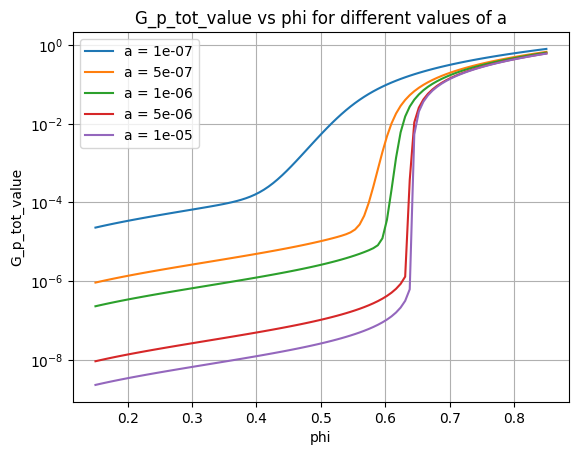

In [88]:
phi_values = np.linspace(0.15, 0.85, 100)

a_values = [1e-7, 5e-7, 1e-6, 5e-6, 10e-6]  

for a_exp in a_values:
    G_p_tot_values = []
    for phi_exp in phi_values:
        G_p_tot_value = compute_G_p_tot(T_exp, phi_exp, a_exp, I_exp, sigma_exp, psi_0_exp) / sigma_exp * a_exp
        G_p_tot_values.append(G_p_tot_value)
    plt.plot(phi_values, G_p_tot_values, label=f'a = {a_exp}')

plt.xlabel('phi')
plt.ylabel('G_p_tot_value')
plt.title('G_p_tot_value vs phi for different values of a')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

In [28]:
# Prompt the user for inputs in the specified units
print("Please enter the following parameters:")

try:
    T_exp = float(input("Temperature T (in Kelvin): "))
    phi_exp = float(input("Volume fraction φ (%, between 0 and 100): ")) * 1e-2
    a_exp = float(input("Droplet size (in microns): ")) * 1e-6 * 0.5 # Convert microns to meters
    I_exp = float(input("Ionic strength I (in mM): ")) * 1e-3   # Convert mM to mol/L
    sigma_exp = float(input("Surface tension σ (in mN/m): ")) * 1e-3  # Convert mN/m to J/m²
    psi_0_exp = float(input("Zeta potential ψ₀ (in mV): ")) * 1e-3    # Convert mV to Volts

    # Validate inputs
    if not (0 < phi_exp < 1):
        raise ValueError("Volume fraction φ % must be between 0 and 100.")
    if T_exp <= 0:
        raise ValueError("Temperature T must be positive.")
    if a_exp <= 0:
        raise ValueError("Droplet size must be positive.")
    if I_exp <= 0:
        raise ValueError("Ionic strength I must be positive.")
    if sigma_exp <= 0:
        raise ValueError("Surface tension σ must be positive.")

    # Compute G_p_tot
    G_p_tot_value = compute_G_p_tot(T_exp, phi_exp, a_exp, I_exp, sigma_exp, psi_0_exp)
    if np.isnan(G_p_tot_value) or np.isinf(G_p_tot_value):
        print("The computation resulted in an invalid value. Please check your input parameters.")
    else:
        print(f"\nComputed G_p_tot: {G_p_tot_value} Pa")
except ValueError as ve:
    print(f"Input error: {ve}")
except Exception as e:
    print(f"An error occurred: {e}")


Please enter the following parameters:
Input error: could not convert string to float: ''
